# Estudo de predição das notas de Linguagem e Códigos baseado nas demais notas do Enem 

In [317]:
# Código feito por Dimas Germano Brandão Soares Silva
# github: https://github.com/dimasgb7  
# linkedin: https://www.linkedin.com/in/dimas-silva-201393120/
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

URI_TREINO = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv"
URI_DADOS_NOVOS = "https://github.com/dimasgb7/pedinhomeajuda/blob/master/test_data.csv"

dados_treino = pd.read_csv(URI_TREINO)
dados_treino.columns = ['CN','CH','LC','MT','REDACAO']

dados_teste = pd.read_csv(URI_TESTE)
dados_teste.columns = ['CN','CH','LC','MT','REDACAO']

dados_desafioqt = pd.read_csv(URI_DESAFIOQT)
dados_desafioqt.columns = ['ID','CN','CH','MT','REDACAO']

erro_treino = "Erro ao carregar dados de treino"
erro_teste = "Erro ao carregar dados de teste"
erro_desafioqt = "Erro ao carregar dados de submissão"

assert dados_treino.shape == (150000, 5), erro_treino
assert dados_teste.shape == (20000, 5), erro_teste
assert dados_desafioqt.shape == (10000, 5), erro_desafioqt

In [318]:
import numpy as np
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
#Baseline Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
#Hardcore Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from scipy.stats import uniform, randint

## Feature Engineering
- Explorando algumas features que possam ser relevantes para os algoritimos de decisão;
- A média, a soma das notas e o desvio padrão foram escolhidos para uma primeira avaliação;
- Agrupar os dados baseado na média das notas disponiveis; 

In [450]:
def create_features(dados):
    mean_list = []
    sum_list = []
    group_list = []
    for index in dados.index:
        id_mean = dados.loc[index,['CN','CH','MT'] ].mean()
        id_sum = dados.loc[index, ['CN','CH','MT'] ].sum()
        mean_list.append(id_mean)
        sum_list.append(id_sum)
        group = 0
        if id_mean > 625:
            group = 3
        if 500 <= id_mean <= 625:
            group = 2
        if id_mean < 500:
            group = 1
        group_list.append(group)
        
    
    mean_list = np.array(mean_list)
    sum_list = np.array(sum_list)
    group_list = np.array(group_list)

    assert mean_list.shape[0] == dados.shape[0]
    assert sum_list.shape[0] == dados.shape[0]
    assert group_list.shape[0] == dados.shape[0]
    
    return mean_list,sum_list,group_list

def add_log(dados):
    dados['CN_log+1'] = (dados['CN']+1).transform(np.log)
    dados['CH_log+1'] = (dados['CH']+1).transform(np.log)
    dados['MT_log+1'] = (dados['MT']+1).transform(np.log)
    dados['REDACAO_log+1'] = (dados['REDACAO']+1).transform(np.log)
    dados['MEDIA_log+1'] = (dados['MEDIA']+1).transform(np.log)

In [353]:
mean_list,sum_list,group_list = create_features(dados_treino)
dados_treino['MEDIA'] = mean_list
dados_treino['SUM'] = sum_list
dados_treino['bin'] = group_list

In [354]:
mean_list,sum_list,group_list = create_features(dados_teste)
dados_teste['MEDIA'] = mean_list
dados_teste['SUM'] = sum_list
dados_teste['bin'] = group_list

In [355]:
mean_list,sum_list,group_list = create_features(dados_desafioqt)
dados_desafioqt['MEDIA'] = mean_list
dados_desafioqt['SUM'] = sum_list
dados_desafioqt['bin'] = group_list

In [451]:
add_log(dados_treino)
add_log(dados_teste)
add_log(dados_desafioqt)

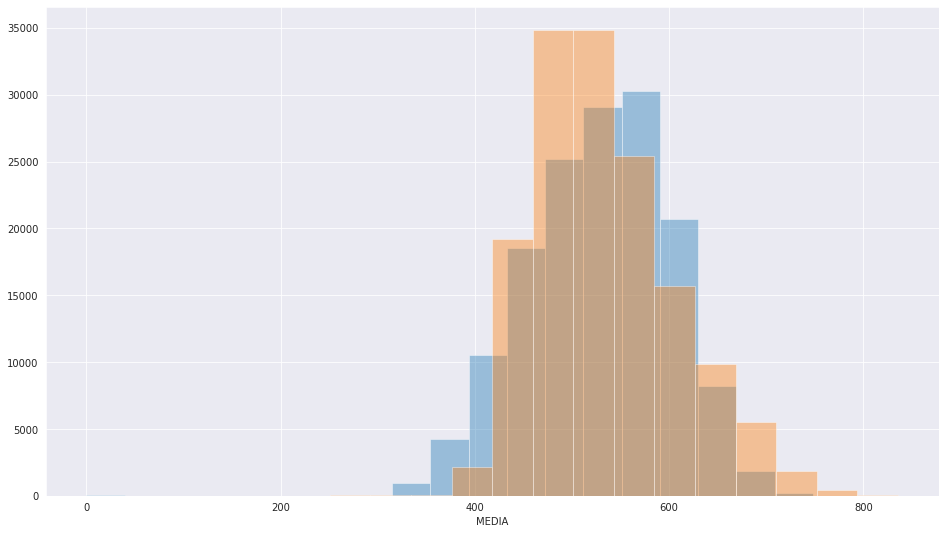

In [356]:
plt.figure(figsize=(16,9))
sns.distplot(dados_treino['LC'], kde=False, bins=20,label='Y_teste')

sns.distplot(dados_treino['MEDIA'], kde=False, bins=20,label='Y_teste')

In [544]:
up = 0.95
low = 0.0
lc_upper_lim = dados_treino['LC'].quantile(0.95)
lc_lower_lim = dados_treino['LC'].quantile(0.05)

ch_upper_lim = dados_treino['CH'].quantile(up)
ch_lower_lim = dados_treino['CH'].quantile(low)

cn_upper_lim = dados_treino['CN'].quantile(up)
cn_lower_lim = dados_treino['CN'].quantile(low)

mt_upper_lim = dados_treino['MT'].quantile(up)
mt_lower_lim = dados_treino['MT'].quantile(low)

red_upper_lim = dados_treino['REDACAO'].quantile(up)
red_lower_lim = dados_treino['REDACAO'].quantile(low)

In [545]:
#DATA TWEAKS
dados_treino_zeros = dados_treino[((dados_treino['CN'] == 0.0) | (dados_treino['CH'] == 0.0) |
             (dados_treino['LC'] == 0.0) | (dados_treino['MT'] == 0.0) | (dados_treino['REDACAO'] == 0.0))]

dados_treino_sem_zeros = dados_treino[  (dados_treino['CN'] > 0.0) & 
                                            (dados_treino['CH'] > 0.0) &
                                            #(dados_treino['LC'] > 0.0) & 
                                            #(dados_treino['REDACAO'] > 0.0)&
                                            (dados_treino['MT'] > 0.0)  ]


dados_treino_limites = dados_treino[        (cn_lower_lim <= dados_treino['CN']) & (dados_treino['CN'] < cn_upper_lim) & 
                                            (ch_lower_lim <= dados_treino['CH']) & (dados_treino['CH'] < ch_upper_lim) &
                                            (red_lower_lim <= dados_treino['REDACAO']) & (dados_treino['REDACAO'] < red_upper_lim) &
                                            (lc_lower_lim <= dados_treino['LC']) & (dados_treino['LC'] < cn_upper_lim) & 
                                            (mt_lower_lim <= dados_treino['MT']) & (dados_treino['MT'] < mt_upper_lim)  ]

dados_treino_limites_log = dados_treino[    (cn_lower_lim < dados_treino['CN_log+1']) & (dados_treino['CN_log+1'] < cn_upper_lim) & 
                                            (ch_lower_lim < dados_treino['CH_log+1']) & (dados_treino['CH_log+1'] < ch_upper_lim) &
                                            (dados_treino['REDACAO_log+1'] < red_upper_lim) &
                                            (lc_lower_lim < dados_treino['LC']) & (dados_treino['LC'] < cn_upper_lim) & 
                                            (mt_lower_lim < dados_treino['MT_log+1']) & (dados_treino['MT_log+1'] < mt_upper_lim)  ]

#Verificando se as modificações ocorreram baseado no formato do dados
display(dados_treino.shape)
display(dados_treino_zeros.shape)
display(dados_treino_sem_zeros.shape)
display(dados_treino_limites_log.shape)


(150000, 13)

(3210, 13)

(149822, 13)

(132205, 13)

## Dividindo dados em treino e teste e escolhendo as features

In [553]:
np.random.seed(43267)
coluna_label = 'LC'
coluna_features = ['CN', 'CH', 'MT', 'REDACAO']
coluna_NR = ['MEDIA_log+1','bin']
coluna_log  = ['CN_log+1','CH_log+1','MT_log+1','REDACAO_log+1']
coluna_F = coluna_log + coluna_NR

X_treino = dados_treino[coluna_F].to_numpy()
Y_treino = dados_treino[coluna_label].to_numpy()
X_teste = dados_teste[coluna_F].to_numpy()
Y_teste = dados_teste[coluna_label].to_numpy()

In [473]:
def display_scores(scores):
    print('MSE Scores: {}'.format(scores))
    print('Mse Mean: {} '.format(np.mean(scores)))
    print('MSE std: {}'.format(np.std(scores)))
    
def plot_scatter(predicao):
    plt.figure(figsize=(9,6))
    sns.set_style('darkgrid')
    sns.scatterplot(x=X_teste[:,1],y=Y_teste, color='blue')
    sns.scatterplot(x=X_teste[:,1],y=predicao, color='red')
    plt.show()
def plot_dist(predicao):
    plt.figure(figsize=(9,6))
    sns.distplot(Y_teste, kde=False, bins=20, label='Y_teste')
    sns.distplot(predicao, kde=False, bins=20, label='predicao')
    plt.legend()
    plt.show()
    
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## BASELINE

MSE Scores: [72.307897 72.307897 72.307897]
Mse Mean: 72.30789700382394 
MSE std: 0.0


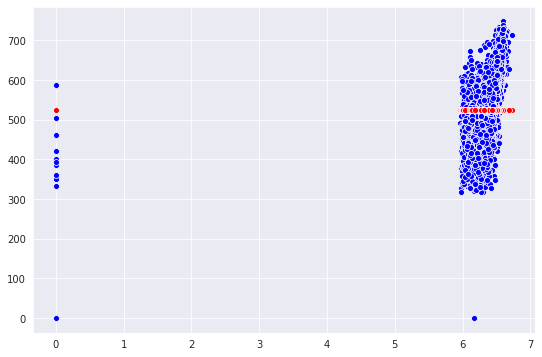

In [533]:
scores = []
np.random.seed(43267)
for en in range(1,4):
    modelo = DummyRegressor()
    modelo.fit(X_treino, Y_treino)
    predicao = modelo.predict(X_teste)
    mse = mean_squared_error(Y_teste, predicao)
    scores.append(mse)
display_scores(np.sqrt(scores))
plot_scatter(predicao)

MSE Scores: [47.99947201 47.99947201 47.99947201 47.99947201]
Mse Mean: 47.99947200791774 
MSE std: 0.0


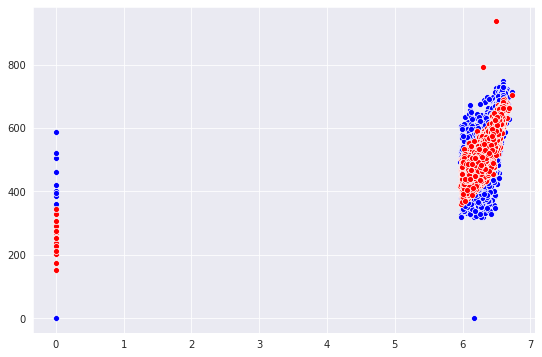

In [551]:
scores = []
predicoes = []
mse = 0
for coco in range(0,4):
    modelo = LinearRegression()
    modelo.fit(X_treino, Y_treino)
    predicao = modelo.predict(X_teste)
    predicoes.append(predicao)
    mse = mean_squared_error(Y_teste, predicao)
    scores.append(mse)
display_scores(np.sqrt(scores))
plot_scatter(predicao)

## GRADIENT BOOSTING REGRESSOR

MSE Scores: [2044.3438323350072, 2044.3438323350072, 2044.3438323350072, 2044.3438323350072, 2044.3438323350072]
Mse Mean: 2044.343832335007 
MSE std: 2.2737367544323206e-13


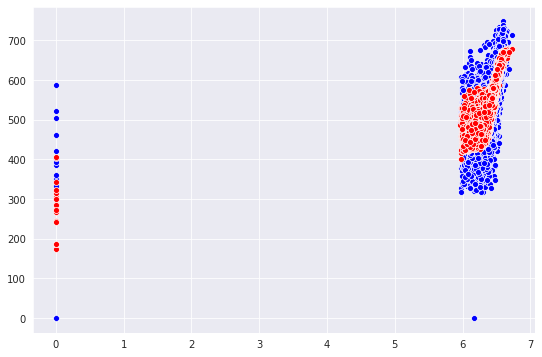

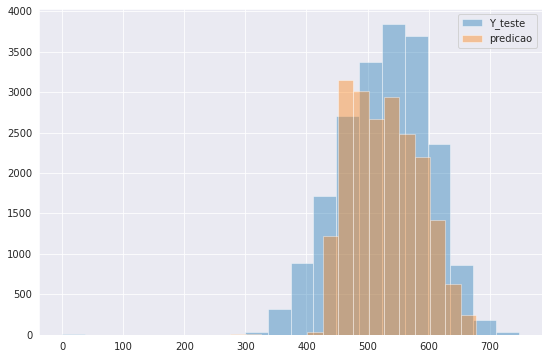

In [568]:
rank1 = {'n_estimators': 64, 
         'max_features': 2, 
         'max_depth': 4.0, 
         'learning_rate': 0.1} #45.315
test_params = {'loss': 'ls', 
               'learning_rate': 0.1, 
               'n_estimators':64, 
               'max_depth':5,'max_features':2} #45.37
best0 = {
    'learning_rate' : 0.03, 
    'n_estimators': 675, 
    'min_samples_split': 33, 
    'min_samples_leaf': 70,
    'random_state': 42}

best1 = {
    'learning_rate' : 0.1, 
    'n_estimators': 675, 
    'min_samples_split': 33, 
    'max_depth': 4.0,
    'max_features':2,
    'min_samples_leaf': 70,
    'random_state': 42}


scores = []
predicoes = []
for en in range(1,6):
    modelo = GradientBoostingRegressor(**best0)
    modelo.fit(X_treino, Y_treino)
    predicao = modelo.predict(X_teste)
    predicoes.append(predicao)
    mse = mean_squared_error(Y_teste, predicao)
    scores.append(mse)
display_scores(scores)
plot_scatter(predicoes[scores.index(min(scores))])
plot_dist(predicoes[scores.index(min(scores))])

In [ ]:
#Hyper Parameters Search
modelo = GradientBoostingRegressor()
params = {
    "learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
    "max_depth": np.linspace(1, 32, 32, endpoint=True), 
    "max_features": range(1,X_treino.shape[1])
}

search = RandomizedSearchCV(modelo, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)
search.fit(X_treino, Y_treino)
report_best_scores(search.cv_results_, 1)

## XGB REGRESSOR

In [ ]:
#XGB REGRESSOR
scores = []
predicoes = []
rank1 = {'colsample_bytree': 0.8808345646069895, 
         'gamma': 0.13547882125756494, 
         'learning_rate': 0.06995553756712491, 
         'max_depth': 4, 'n_estimators': 105, 
         'subsample': 0.9799199653167696} #45.78
rank2 = {'colsample_bytree': 0.8935310086091695, 
         'gamma': 0.3344620298315498, 
         'learning_rate': 0.28925026952157096, 
         'max_depth': 5, 'n_estimators': 147, 
         'subsample': 0.7123089449763423} #45.78
new_rank = {'colsample_bytree': 0.9266653415629146, 'gamma': 0.11439908274581123, 'learning_rate': 0.053093972948637894, 'max_depth': 4, 'n_estimators': 121, 'subsample': 0.9521871356061031}

for en in range(1,6):
    modelo = XGBRegressor(objective="reg:squarederror",random_state = 42, param_grid = new_rank)
    modelo.fit(X_treino, Y_treino)
    predicao = modelo.predict(X_teste)
    predicoes.append(predicao)
    scores.append(mean_squared_error(Y_teste, predicao))
display_scores(np.sqrt(scores))
plot_scatter(predicoes[0])
plot_dist(predicoes[scores.index(min(scores))])

In [ ]:
#HyperParameter Search

modelo = XGBRegressor(objective="reg:squarederror", random_state = 42)
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(modelo, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_treino, Y_treino)

report_best_scores(search.cv_results_, 1)

## SAVE MODEL RESULT TO CSV FILE

In [566]:
#atribuir ao MODELO o nome do seu melhor modelo
#from google.colab import files

MODELO = modelo
X_desafioqt = dados_desafioqt[coluna_F].to_numpy()
predicao_desafioqt = MODELO.predict(X_desafioqt)


desafio_df = pd.DataFrame(dados_desafioqt.ID)
desafio_df['NU_NOTA_LC'] = predicao_desafioqt

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 
#files.download('PREDICAO_DESAFIOQT.csv')

In [567]:
desafio_df

,ID,NU_NOTA_LC
0,0,505.054581
1,1,583.813742
2,2,519.660915
3,3,463.960975
4,4,529.476698
...,...,...
9995,9995,518.920671
9996,9996,465.839313
9997,9997,529.320436
9998,9998,579.323897
